## Data preparing

Dataset: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

In [41]:
import zipfile

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

from tqdm import tqdm

In [42]:
datazip_path = './kc_house_data.csv.zip'

with zipfile.ZipFile(datazip_path) as zip_file:
	zip_file.extractall('./dataset')

In [43]:
data_frame = pd.read_csv('./dataset/kc_house_data.csv')
data_frame.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [44]:
# Check missing values
print(data_frame.isnull().sum())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


Target variable *price* -- the selling price of the house

In [45]:
data_frame.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Column description:
- id - Unique identifier for each house.
- date - The date the house was sold.
- price - The selling price of the house.
- bedrooms - Number of bedrooms in the house.
- bathrooms - Number of bathrooms in the house (including fractional values for half baths).
- sqft_living - The living area of the home in square feet.
- sqft_lot - The square footage of the lot.
- floors - The number of floors in the home.
- waterfront - Waterfront view (1 - yes, 0 - no).
- view -  Rating of the view from the home (on a scale of 0 to 4).
- condition - The condition of the home (on a scale of 1 to 5).
- grade - The construction and design grade of the home (on a scale of 1 to 13).
- sqft_above - Area of living space above ground level, in square feet.
- sqft_basement - Area of living space in the basement in square feet.
- yr_built - Year the house was built.
- yr_renovated - Year the home was last renovated (0 if no renovations).
- zipcode - The zip code where the house is located.
- lat - Latitude of the house.
- long - The longitude of the house.
- sqft_living15 - Living area of the house nearest to this house, in square feet.
- sqft_lot15 - Square footage of the lot nearest to this house, in square feet.

Let's remove the *id*, *date*, *zipcode*, *lat*, *long* columns as they have no effect on the price value

In [46]:
data_frame_backup = data_frame.copy()
data_frame = data_frame.drop(["id", "date", "zipcode", "lat", "long"], axis=1)

<Axes: >

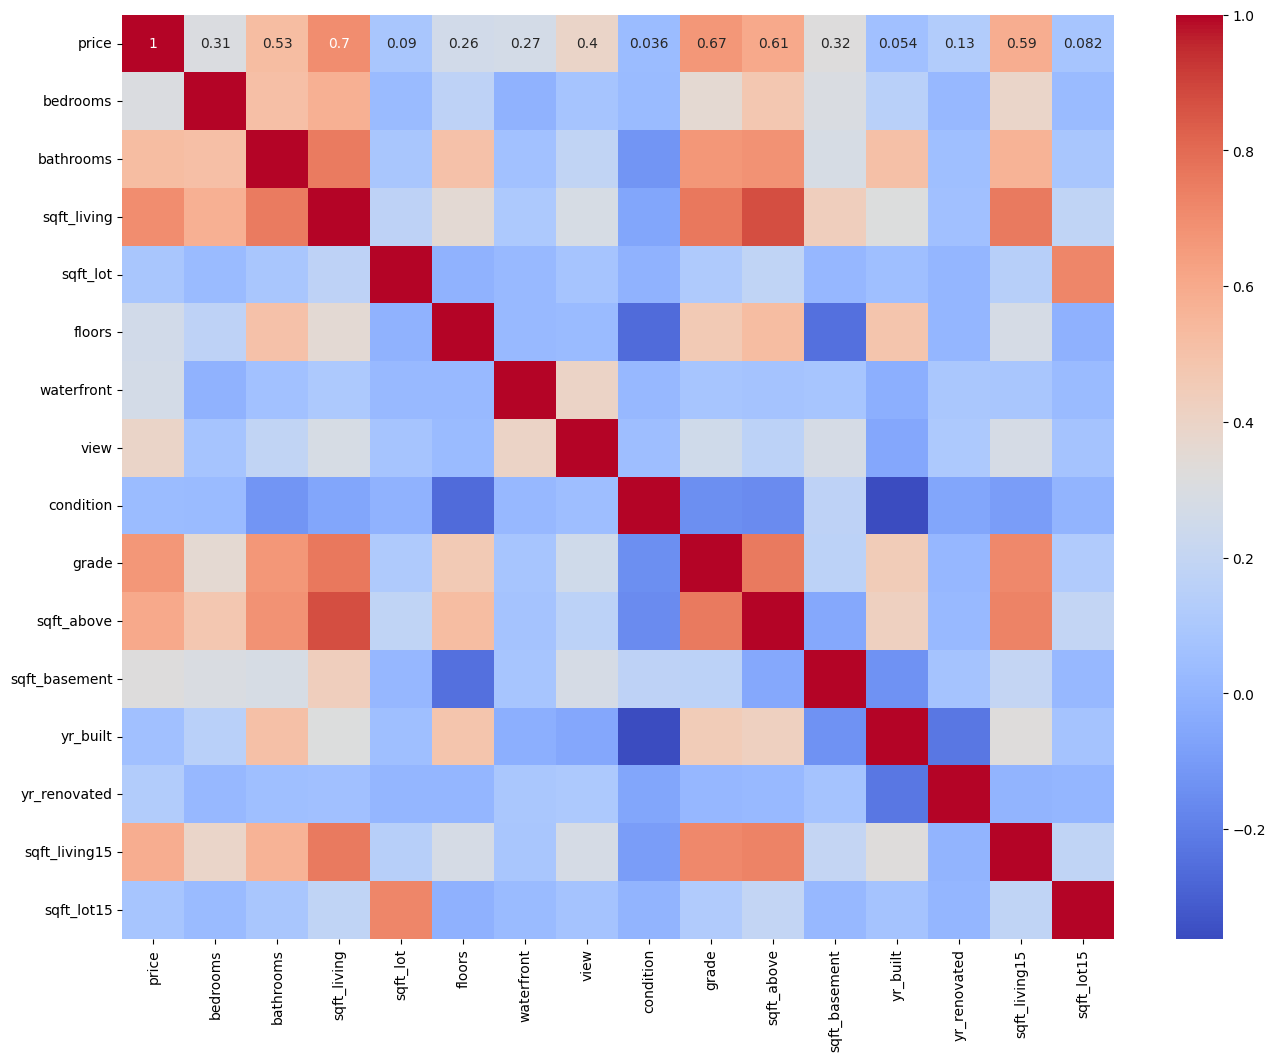

In [47]:
corr_matrix = data_frame.corr()

fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)

In [48]:
# standartization the data
continuous_features = list(data_frame.columns)
continuous_features.remove('waterfront')

scaled_features = {}

for field in continuous_features:
    mean, std = data_frame[field].mean(), data_frame[field].std()
    scaled_features[field] = [mean, std]
    data_frame.loc[:, field] = (data_frame[field] - mean) / std

In [49]:
# Split the data
X = data_frame.drop('price', axis=1)
y = data_frame['price']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 15129
Validation size: 3242
Test size: 3242


Create the dataloader

In [50]:
train_features, train_targets = torch.Tensor(X_train.values).float(), torch.Tensor(y_train.values.reshape(-1, 1)).float()
val_features, val_targets = torch.Tensor(X_val.values).float(), torch.Tensor(y_val.values.reshape(-1, 1)).float()
test_features, test_targets = torch.Tensor(X_test.values).float(), torch.Tensor(y_test.values.reshape(-1, 1)).float()


In [51]:
train_dataset=TensorDataset(train_features, train_targets)
test_dataset=TensorDataset(test_features, test_targets)
val_dataset=TensorDataset(val_features, val_targets)


In [52]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True)

## Model architecture

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [54]:
class PriceRegressionModel(nn.Module):
	def __init__(self):
		super(PriceRegressionModel, self).__init__()
		self.fc1 = nn.Linear(15, 10)
		self.fc2 = nn.Linear(10, 5)
		self.fc3 = nn.Linear(5, 1)
		self.activation = nn.LeakyReLU()

	def forward(self, x):
		x = self.fc1(x)
		x = self.activation(x)

		x = self.fc2(x)
		x = self.activation(x)

		x = self.fc3(x)
		return x

In [55]:
model = PriceRegressionModel()
model.to(device)

summary(model, input_size=(1,15))

Layer (type:depth-idx)                   Output Shape              Param #
PriceRegressionModel                     [1, 1]                    --
├─Linear: 1-1                            [1, 10]                   160
├─LeakyReLU: 1-2                         [1, 10]                   --
├─Linear: 1-3                            [1, 5]                    55
├─LeakyReLU: 1-4                         [1, 5]                    --
├─Linear: 1-5                            [1, 1]                    6
Total params: 221
Trainable params: 221
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Train and validation

In [56]:
class PricePredictor:
    def __init__(self, model, criterion, optimizer) -> None:
        self._model = model
        self._criterion = criterion
        self._optimizer = optimizer
        
        self._train_losses = []
        self._val_losses = []
    
    def train(self, epoch):
        print_flag = epoch % 10 == 0
        
        if print_flag:
            print(f'\nEpoch : {epoch}')

        self._model.train()
        running_loss = 0
        for data in train_loader:
            inputs, targets = data[0].to(device),data[1].to(device)
            self._optimizer.zero_grad()
            
            outputs = model(inputs)

            loss = self._criterion(outputs,targets)
            loss.backward()
            self._optimizer.step()

            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        self._train_losses.append(train_loss)
        
        if print_flag:
            print(f'Loss train value for epoch: {train_loss:.4f}')
        
    def val(self, epoch):
        print_flag = epoch % 10 == 0
        
        if print_flag:
            print(f'\nEpoch : {epoch}')
        
        model.eval()
        running_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, targets = data[0].to(device),data[1].to(device)
                
                outputs = model(inputs)
                
                loss = self._criterion(outputs,targets)
                running_loss += loss.item()
            val_loss = running_loss / len(val_loader)
            self._val_losses.append(val_loss)
            if print_flag:
                print(f'Loss validation value for epoch: {val_loss:.4f}')
            
    def get_train_losses(self) -> list:
        return self._train_losses
    
    def get_val_losses(self) -> list:
        return self._val_losses

In [57]:
max_epoch = 120

criterion = nn.MSELoss(reduction='mean') # функция ошибки
optimizer = torch.optim.SGD(model.parameters(), lr=0.001) # алгоритм оптимизации

price_predictor = PricePredictor(model=model, criterion=criterion, optimizer=optimizer)

for epoch in range(1, max_epoch + 1):
    price_predictor.train(epoch)
    price_predictor.val(epoch)


Epoch : 10
Loss train value for epoch: 0.3935

Epoch : 10
Loss validation value for epoch: 0.4827

Epoch : 20
Loss train value for epoch: 0.3401

Epoch : 20
Loss validation value for epoch: 0.4086

Epoch : 30
Loss train value for epoch: 0.3140

Epoch : 30
Loss validation value for epoch: 0.3867

Epoch : 40
Loss train value for epoch: 0.3055

Epoch : 40
Loss validation value for epoch: 0.3640

Epoch : 50
Loss train value for epoch: 0.2983

Epoch : 50
Loss validation value for epoch: 0.3575

Epoch : 60
Loss train value for epoch: 0.2900

Epoch : 60
Loss validation value for epoch: 0.3522

Epoch : 70
Loss train value for epoch: 0.2866

Epoch : 70
Loss validation value for epoch: 0.3433

Epoch : 80
Loss train value for epoch: 0.2817

Epoch : 80
Loss validation value for epoch: 0.3402

Epoch : 90
Loss train value for epoch: 0.2778

Epoch : 90
Loss validation value for epoch: 0.3346

Epoch : 100
Loss train value for epoch: 0.2774

Epoch : 100
Loss validation value for epoch: 0.3292

Epoch :

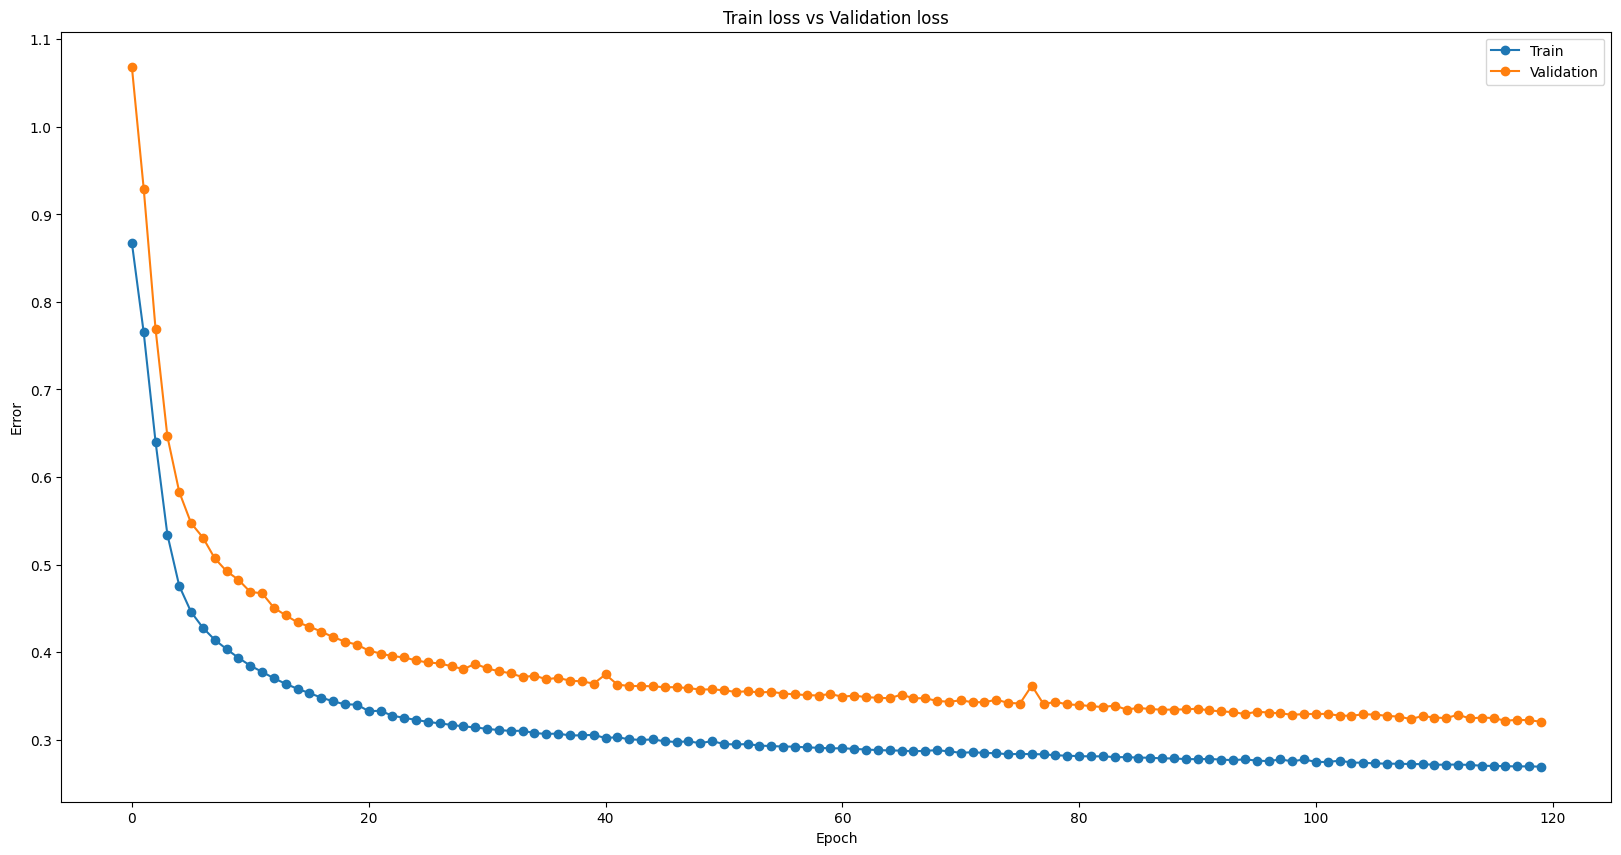

In [58]:
train_losses = price_predictor.get_train_losses()
val_losses = price_predictor.get_val_losses()

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Train','Validation'])
plt.title('Train loss vs Validation loss')
plt.show()

## Prediction

In [59]:
mean = scaled_features['price'][0]
std = scaled_features['price'][1]

In [60]:
prediction = []
target = []

for data in tqdm(test_loader):
    inputs, targets = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    prediction.append(outputs.to('cpu').detach().numpy() * std + mean)
    target.append(targets.to('cpu').detach().numpy() * std + mean)

100%|██████████| 51/51 [00:00<00:00, 867.92it/s]


In [61]:
prediction = np.array(prediction[:-1]).flatten()
target = np.array(target[:-1]).flatten()

In [62]:
print(f"R2 score: {r2_score(target, prediction)}")

R2 score: 0.7430562930512149


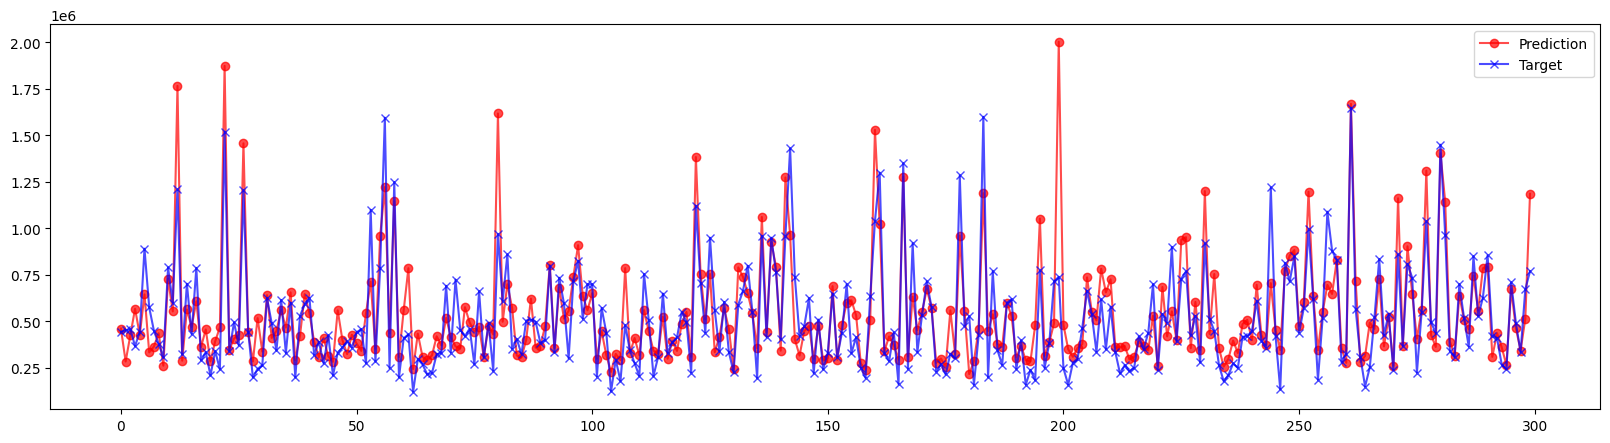

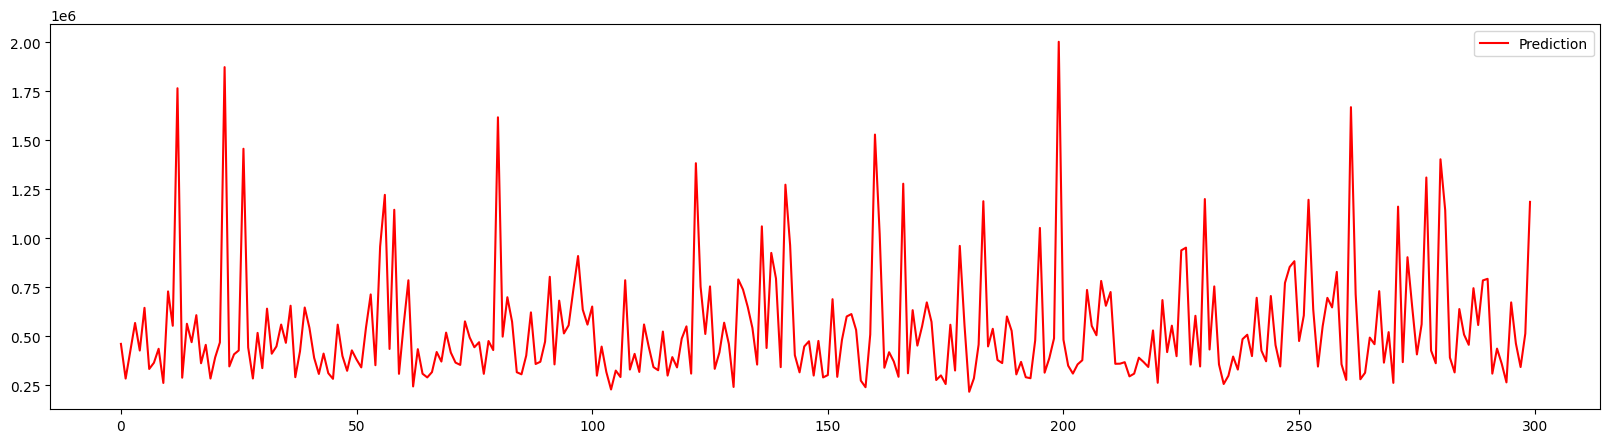

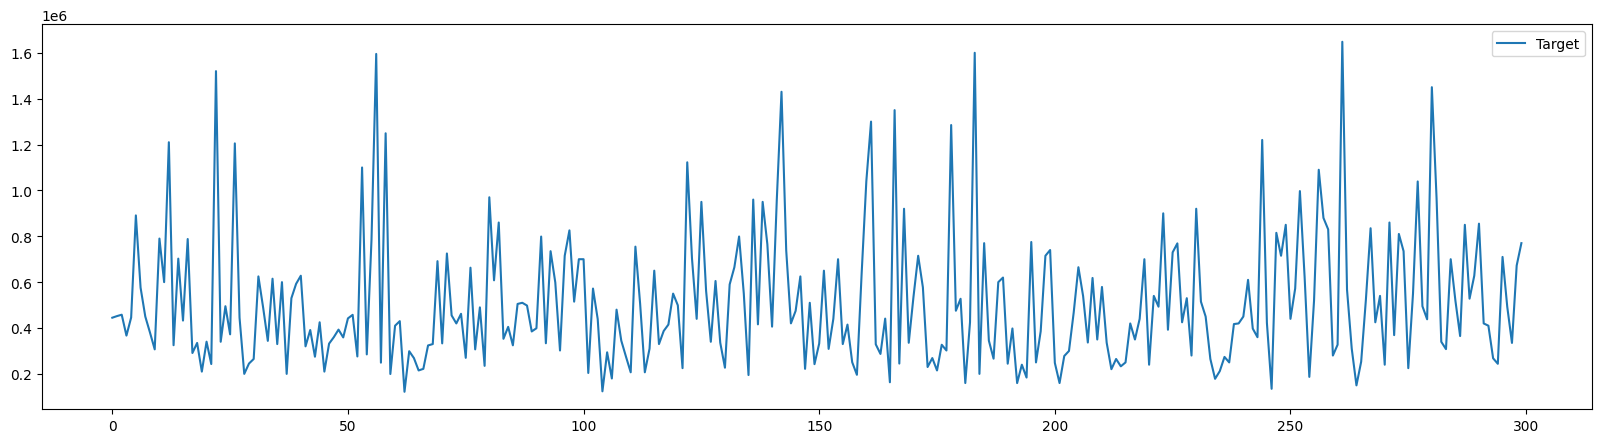

In [63]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(prediction[:300], label='Prediction', color='red', marker='o', alpha=0.7)
ax.plot(target[:300], label='Target', color='blue', marker='x', alpha=0.7)
ax.legend()

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(prediction[:300], label='Prediction', color='red')
ax.legend()

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(target[:300], label='Target')
ax.legend()